### Setup
https://medium.com/@lumeilin301/optimized-a-promotional-campaign-by-using-uplift-models-and-machine-learning-3a01cf80eec1

In [1]:
# Import libraries
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns, math, os, warnings 
warnings.filterwarnings('ignore')

### Data Exploration

In [4]:
# Import data
df = pd.read_csv('data.csv')
print('df shape: {0}'.format(df.shape))
df.head()

df shape: (64000, 9)


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
# Checking for null data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
recency          64000 non-null int64
history          64000 non-null float64
used_discount    64000 non-null int64
used_bogo        64000 non-null int64
zip_code         64000 non-null object
is_referral      64000 non-null int64
channel          64000 non-null object
offer            64000 non-null object
conversion       64000 non-null int64
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


there is no null data in this dataset

In [8]:
# Checking for object data
df.describe(include=np.object)

,zip_code,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


In [7]:
# Checking unique object data
object_cols = [col for col in df.columns if df[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df[obj].unique():
        print("{} {}".format(unique,sum(df[obj] == unique)))


 zip_code
Surburban 28776
Rural 9563
Urban 25661

 channel
Phone 28021
Web 28217
Multichannel 7762

 offer
Buy One Get One 21387
No Offer 21306
Discount 21307


### Data Preprocessing

In [10]:
# label for classifier
df['campaign_group'] = 'treatment'
 
df.loc[df.offer == 'No Offer', 'campaign_group'] = 'control'

#0 = CN: Control Non-Responders
df['target_class'] = 0

#1 = CR: Control Responders
df.loc[(df.campaign_group == 'control') & (df.conversion > 0),'target_class'] = 1

#2 = TN: Treatment Non-Responders
df.loc[(df.campaign_group == 'treatment') & (df.conversion == 0),'target_class'] = 2

#3 = TR: Treatment Responders
df.loc[(df.campaign_group == 'treatment') & (df.conversion > 0),'target_class'] = 3

### Modeling

In [13]:
from sklearn.cluster import KMeans

#creating clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['history']])
df['history_cluster'] = kmeans.predict(df[['history']])

In [14]:
#dropping unnecessary columns
df_model = df.drop(['offer','campaign_group','conversion'],axis=1) 
df_model = pd.get_dummies(df_model)

In [17]:
import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#create feature set and labels
X = df_model.drop(['target_class'],axis=1)
y = df_model.target_class#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

In [18]:
#fitting the model and predicting the probabilities
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
class_probs = xgb_model.predict_proba(X_test)

In [19]:
proba = xgb_model.predict_proba(df_model.drop(['target_class'],axis=1))
df_model['proba_CN'] = proba[:,0] 
df_model['proba_CR'] = proba[:,1] 
df_model['proba_TN'] = proba[:,2] 
df_model['proba_TR'] = proba[:,3]

#calculate uplift score for customers
df_model['uplift_score'] = df_model.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')

#assign it back to main dataframe
df['uplift_score'] = df_model['uplift_score']
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group,target_class,history_cluster,uplift_score
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,treatment,2,1,0.066555
1,6,329.08,1,1,Rural,1,Web,No Offer,0,control,0,3,0.140476
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,treatment,2,1,0.145965
3,9,675.83,1,0,Rural,1,Web,Discount,0,treatment,2,0,0.131215
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,treatment,2,1,0.138555


### Evaluation - QINI Curve
Qini is a generalization of gini curve for Uplift model, introduced by Radcliffe. The QINI (Uplift value) can be calculated as:
1. QINI = TR - [(CR*T)/C]

Thus can be normalized in percentage as:
2. QINI = (TR/T) - (CR/C)

In [21]:
# Creat new dataframe
ranked = pd.DataFrame({'n':[], 'target_class':[]})
ranked['target_class'] = df['target_class']
ranked['uplift_score'] = df['uplift_score']

# Add proportion
ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)

# Data Ranking 
ranked = ranked.sort_values(by='n').reset_index(drop=True)
ranked.head()

,n,target_class,uplift_score
0,0.000016,3,0.569834
1,0.000031,3,0.562316
2,0.000047,3,0.525927
3,0.000063,2,0.517700
4,0.000078,3,0.506106


In [22]:
uplift_model, random_model = ranked.copy(), ranked.copy()

# Using Treatment and Control Group to calculate the uplift (Incremental gain)
C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
ranked['cr'] = 0
ranked['tr'] = 0

ranked.loc[ranked.target_class == 1,'cr'] = 1
ranked.loc[ranked.target_class == 3,'tr'] = 1
ranked['cr/c'] = ranked.cr.cumsum() / C
ranked['tr/t'] = ranked.tr.cumsum() / T

# Calculate and put the uplift and random value into dataframe
uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)

# Add q0
q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])

uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
random_model = pd.concat([q0, random_model]).reset_index(drop = True)  

# Add model name & concat
uplift_model['model'] = 'Uplift model'
random_model['model'] = 'Random model'
merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)

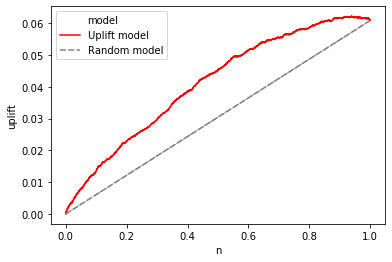

In [23]:
ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])

# Plot settings
sns.set_style('whitegrid')
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('Proportion targeted',fontsize=15)
plt.ylabel('Uplift',fontsize=15)
plt.subplots_adjust(right=1)
plt.subplots_adjust(top=1)
plt.legend(fontsize=12)
ax.tick_params(labelsize=15)
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')

### Result
The QINI curve visualizes the performance of the Uplift model and it show that the Uplift model can give more uplift than random model (without model).